In [63]:
import pandas as pd
import sklearn as sk
import seaborn as sn
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Principal Component Analysis

### Data Munging
Let's load the data first. Some initial prep is needed. You have to make sure that the index column is not in your dataframe. Then separate the dataframe into the features and the target. We do *not* want to run PCA with cover type!

In [64]:
df = pd.read_csv('train_and_test.csv', index_col=0)

In [65]:
features = df[df.columns[:54]]
target = df['Cover_Type']

A good way to make sure that your dataset is what you want it to be is by using the .head() function. It is not enough but at least the first 5 rows look good lol. 

In [66]:
features.head()

,Elevation,Aspect,Slope,Horizontal_Dist_To_Water,Vertical_Dist_To_Water,Horizontal_Dist_To_Roadways,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Horizontal_Dist_To_Fire_Points,...,Soiltype31,Soiltype32,Soiltype33,Soiltype34,Soiltype35,Soiltype36,Soiltype37,Soiltype38,Soiltype39,Soiltype40
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0
5,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,0
7,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,0,0


### PCA Take I
Alright, now that stuff is out of the way. Let's do some PCA! So first what happens is that you have a PCA object that takes in some parameters. I am using all default ones right now, but I might change that eventually. 

In [67]:
pca_feat = PCA() # this is the PCA object
pca_feat.fit(features) # fit the PCA object on the features that you have

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [68]:
type(PCA)

abc.ABCMeta

So now we want to see what the explained variances are. I am using seaborn to visualize the variances so I need to mess around with the explained variances a little bit to be able to plug it in neatly to a seaborn function.

In [69]:
explained_variances = pd.DataFrame(pca_feat.explained_variance_ratio_, columns=['variance'])
explained_variances['index'] = range(1, len(explained_variances) + 1)
explained_variances.head()

,variance,index
0,0.662744,1
1,0.307020,2
2,0.017730,3
3,0.008603,4
4,0.003069,5


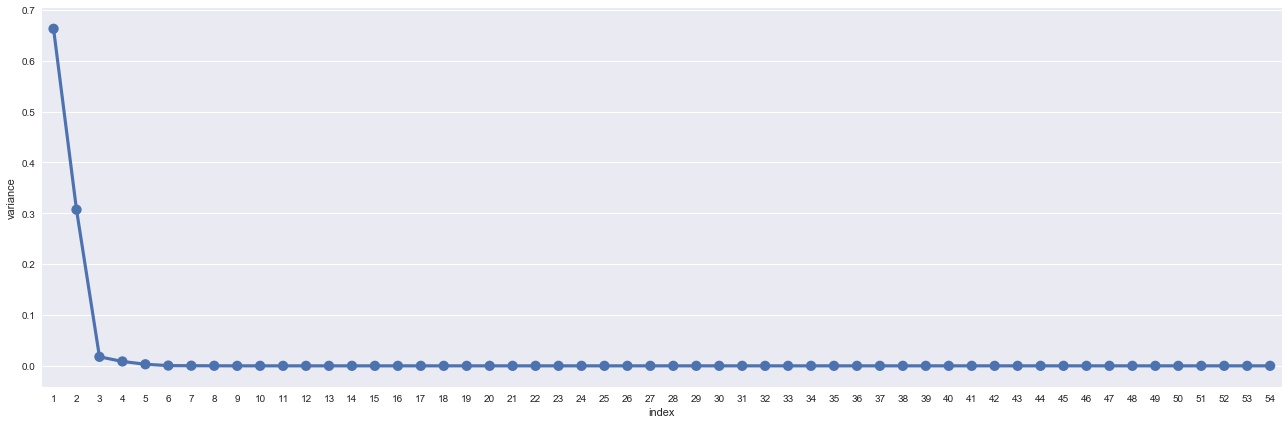

In [70]:
%matplotlib inline
sn.factorplot(x = 'index', y = 'variance', data = explained_variances, size=6, aspect=3)

This plot is very striking. From PCA, it appears we need to use only ~3-4 top PCA features. Let's magnify the image a little bit and zoom in on just 1 - 10.

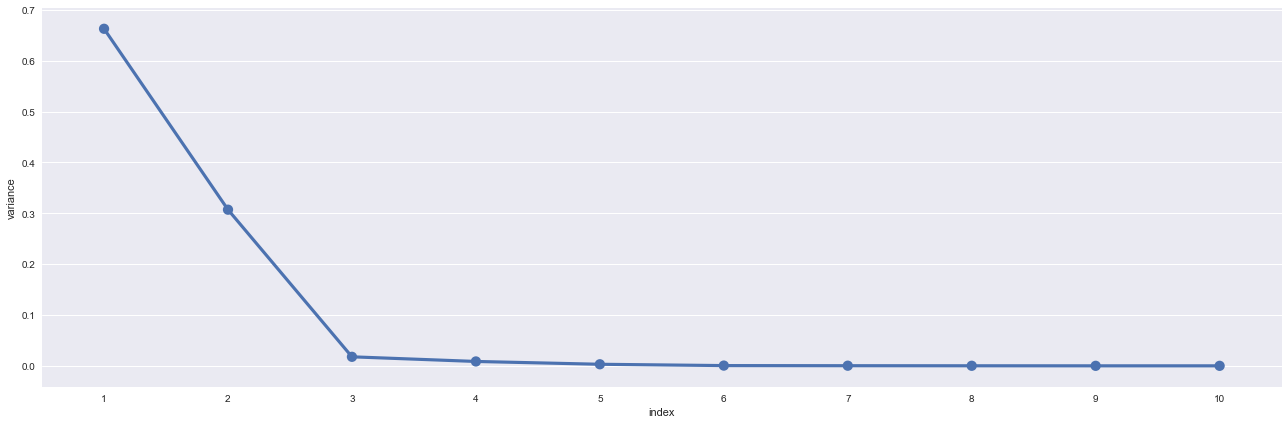

In [71]:
sn.factorplot(x = 'index', y = 'variance', data = explained_variances[:10], size=6, aspect=3)

### Comments for other models
At this point, I am not entirely sure how we would want to go about using these features. One of the problems is that this PCA is run on the whole training dataset. Another thing is that sklearn allows you to pipeline models. This means that you create a 'pipeline' which is a set of data operations that you can chain and then train the entire train_and_test dataset on your pipeline. I am not 100% sure what this means to our testing (not safe) and cross-validation so we should discuss that. I also feel that instead of using the data that I have here, it would be better for you guys to run PCA separately for your models so you can use the pipelining thing, as well as tweaking it based on how you want to cross-validate and so on.

### PCA with just the first two components:

In [72]:
n_comp = 2
pca_2_features = PCA(n_components=n_comp)
features_transformed = pca_2_features.fit_transform(features)

In [73]:
'''
plt.close('all')
trans_feat_plot = plt.figure(figsize=(8,6))
x_vals = features_transformed[:,0]
y_vals = features_transformed[:,1]
tar = np.array(target)-1
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'navy', 'blue']
for i in range(10000):
    col = colors[tar[i]]
    plt.scatter(x_vals[i], y_vals[i], color = col)
'''

"\nplt.close('all')\ntrans_feat_plot = plt.figure(figsize=(8,6))\nx_vals = features_transformed[:,0]\ny_vals = features_transformed[:,1]\ntar = np.array(target)-1\ncolors = ['red', 'blue', 'green', 'yellow', 'orange', 'navy', 'blue']\nfor i in range(10000):\n    col = colors[tar[i]]\n    plt.scatter(x_vals[i], y_vals[i], color = col)\n"

### KNN with training/testing:

In [88]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
train_features = train[train.columns[:54]]
train_target = train['Cover_Type']
test_features = test[test.columns[:54]]
test_target = test['Cover_Type']

In [89]:
from sklearn.neighbors import KNeighborsClassifier
k=3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_features, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [90]:
predicted = knn.predict(test_features)
actual = np.array(test_target)

In [91]:
result = [None]*len(actual)
for i in range(len(actual)):
    result[i] = (predicted[i]==actual[i])

In [92]:
correct_count = [i for i in result if i==True]
correct_rate = float(len(correct_count))/len(result)
correct_rate

0.9661517565513599